### Importación de librerías

In [14]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


### Carga y verificación de datos

In [15]:
file_path = r"C:\Users\Danie\OneDrive\Escritorio\Workshop03\data\merged.csv"

try:
    df = pd.read_csv(file_path)
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo no se encontró en la ruta: {file_path}")
    exit()
except Exception as e:
    print(f"Error al leer el archivo CSV: {e}")
    exit()

Archivo cargado correctamente.


### Features y expansión polinómica

In [16]:
# Nuevas características
df["gdp_life_combo"] = df["gdp_per_capita"] * df["life_expectancy"]
df["support_per_gdp"] = df["social_support"] / (df["gdp_per_capita"] + 1e-5)
df["freedom_corr"] = df["freedom"] * df["corruption"]

# Expansión polinómica
features_original = ["gdp_per_capita", "social_support", "freedom", "corruption", "life_expectancy"]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df[features_original])
poly_feature_names = poly.get_feature_names_out(features_original)
df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
df_extended = pd.concat([df, df_poly], axis=1)


### División y escalado

In [17]:
features_extended = [col for col in df_extended.columns if col not in ["happiness_score", "country"]]
target = "happiness_score"

X = df_extended[features_extended]
y = df_extended[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Definición de modelos

In [18]:
linear_regression = LinearRegression()
ridge_regression = Ridge(random_state=42)
random_forest = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=42, n_jobs=-1)
gradient_boosting = GradientBoostingRegressor(n_estimators=400, learning_rate=0.015, max_depth=4, subsample=0.8, random_state=42)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, learning_rate=0.025, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)


### Modelo ajustado (GridSearchCV)

In [19]:
param_grid_meta = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.02],
    'max_depth': [3, 4]
}

grid_search_meta = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_meta,
    cv=5,
    scoring='r2',
    n_jobs=-1
)


### Modelo de Stacking y entrenamiento

In [20]:
stacking_model = StackingRegressor(
    estimators=[
        ('lr', linear_regression),
        ('ridge', ridge_regression),
        ('rf', random_forest),
        ('gb', gradient_boosting),
        ('xgb', xgboost_model)
    ],
    final_estimator=grid_search_meta,
    cv=5
)

print("Entrenando modelo de stacking con búsqueda de hiperparámetros...")
stacking_model.fit(X_train_scaled, y_train)


Entrenando modelo de stacking con búsqueda de hiperparámetros...


StackingRegressor(cv=5,
                  estimators=[('lr', LinearRegression()),
                              ('ridge', Ridge(random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=400,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.015,
                                                         max_depth=4,
                                                         n_estimators=400,
                                                         random_state=42,
                                                         subsample=0.8)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callback...
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=-1,
                                            num_parallel_tree=None, ...))],
                  final_estimator=GridSearchCV(cv=5,
                                               estimator=GradientBoostingRegressor(random_state=42),
                                               n_jobs=-1,
                                               param_grid={'learning_rate': [0.01,
                                                                             0.02],
                                                           'max_depth': [3, 4],
                                                           'n_estimators': [100,
                                                                            200]},
                                               scoring='r2'))

In [21]:
y_pred_stacking = stacking_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_stacking)
mae = mean_absolute_error(y_test, y_pred_stacking)
r2 = r2_score(y_test, y_pred_stacking)

print("="*60)
print("Resultados del Modelo de Stacking con Meta-Modelo Ajustado:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print("="*60)


Resultados del Modelo de Stacking con Meta-Modelo Ajustado:
MSE: 0.2424
MAE: 0.3843
R2 Score: 0.8007


### Guardar el modelo entrenado

In [26]:
model_dir = r"C:\Users\Danie\OneDrive\Escritorio\Workshop03\models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


scaler_path = os.path.join(model_dir, "scaler.pkl")
poly_path = os.path.join(model_dir, "poly_features.pkl")
features_path = os.path.join(model_dir, "features_extended.pkl")
model_path = os.path.join(model_dir, "stacking_tuned_meta_model.pkl")


joblib.dump(scaler, scaler_path)
joblib.dump(poly, poly_path)
joblib.dump(features_extended, features_path)
joblib.dump(stacking_model, model_path)

print(f"Scaler guardado en: {scaler_path}")
print(f"Transformador polinómico guardado en: {poly_path}")
print(f"Columnas de entrenamiento guardadas en: {features_path}")
print(f"Modelo guardado en: {model_path}")

Scaler guardado en: C:\Users\Danie\OneDrive\Escritorio\Workshop03\models\scaler.pkl
Transformador polinómico guardado en: C:\Users\Danie\OneDrive\Escritorio\Workshop03\models\poly_features.pkl
Columnas de entrenamiento guardadas en: C:\Users\Danie\OneDrive\Escritorio\Workshop03\models\features_extended.pkl
Modelo guardado en: C:\Users\Danie\OneDrive\Escritorio\Workshop03\models\stacking_tuned_meta_model.pkl


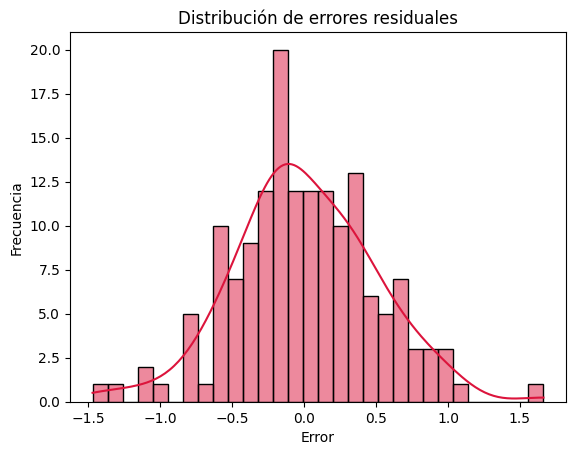

In [23]:
residuals = y_test - y_pred_stacking
sns.histplot(residuals, bins=30, kde=True, color="crimson")
plt.title("Distribución de errores residuales")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()


## Impacto de las variables

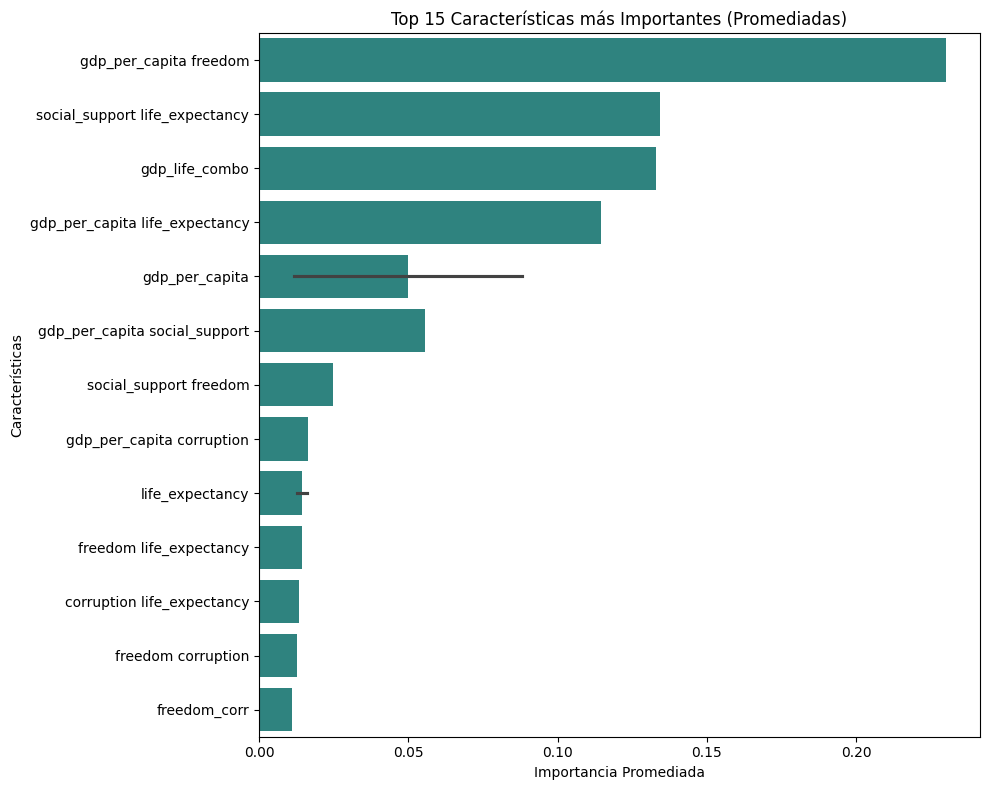

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtener los modelos base entrenados desde el stacking_model
fitted_models = dict(stacking_model.named_estimators_)

# Extraer los modelos entrenados que soportan feature_importances_
rf_fitted = fitted_models['rf']
gb_fitted = fitted_models['gb']
xgb_fitted = fitted_models['xgb']

# Obtener las importancias de cada modelo
importances_rf = rf_fitted.feature_importances_
importances_gb = gb_fitted.feature_importances_
importances_xgb = xgb_fitted.feature_importances_

# Calcular la importancia promedio
avg_importance = (importances_rf + importances_gb + importances_xgb) / 3

# Crear un DataFrame con las importancias
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Seleccionar las top 20 características más importantes
top_n = 15
top_features = importance_df.head(top_n)

# Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, color=sns.color_palette("viridis", 1)[0])
plt.title(f'Top {top_n} Características más Importantes (Promediadas)')
plt.xlabel('Importancia Promediada')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


C:\Users\Danie\AppData\Local\Temp\ipykernel_13412\2485929765.py:16: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Danie\OneDrive\Escritorio\Workshop03\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


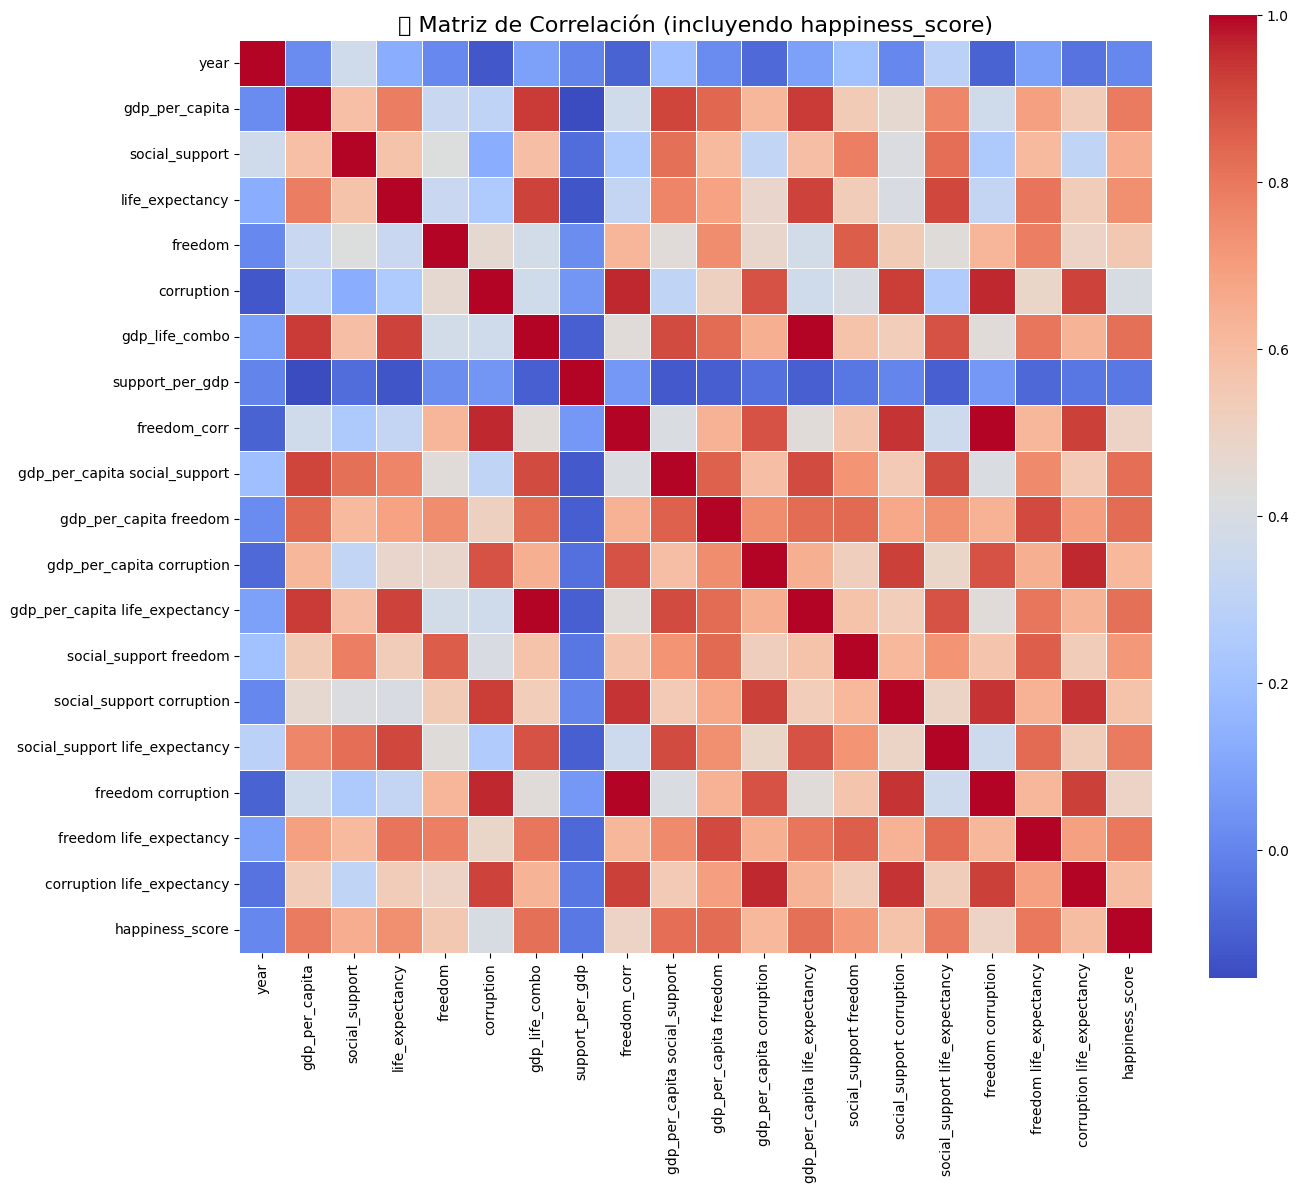

In [25]:
# Combinar features con el target
selected_columns = features_extended + ["happiness_score"]

# Extraer solo columnas únicas y numéricas
corr_data = df_extended[selected_columns]
corr_data = corr_data.loc[:, ~corr_data.columns.duplicated()]  # Eliminar columnas duplicadas
corr_data = corr_data.select_dtypes(include=[np.number])        # Solo numéricas

# Calcular matriz de correlación
corr_matrix = corr_data.corr()

# Visualización
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True, linewidths=0.5)
plt.title("🔗 Matriz de Correlación (incluyendo happiness_score)", fontsize=16)
plt.tight_layout()
plt.show()
